In [75]:
import numpy as np
embeddings_file = "/home/rohan/Documents/projects/interspecies_money/embeddings_analysis/kwitonda_portraits/embeddings/embeddings.npy"
img_fns_file = "/home/rohan/Documents/projects/interspecies_money/embeddings_analysis/kwitonda_portraits/embeddings/file_names.npy"

embeddings = np.load(embeddings_file)
print(embeddings.shape)
ids = np.load(img_fns_file)

(1731, 256)


In [76]:
embeddings_file_db = "/home/rohan/Documents/projects/interspecies_money/gorillavision/reid-system/database_kwitonda/embeddings.npy"
img_fns_file_db = "/home/rohan/Documents/projects/interspecies_money/gorillavision/reid-system/database_kwitonda/labels.npy"

embeddings_db = np.load(embeddings_file_db)
ids_db = np.load(img_fns_file_db)
ids_db = np.array([id.split("_")[0] for id in ids_db])

In [77]:
# Cluster (without doing PCA before)
%pip install scikit-learn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# pca = PCA(n_components=32)
# embeddings = pca.fit_transform(embeddings)

kmeans = KMeans(n_clusters=21)
kmeans.fit(embeddings)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


/home/rohan/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=21)

In [89]:
from collections import defaultdict
import json
import os
import pandas as pd

# Load sequences
sequences_file = "/home/rohan/Documents/projects/interspecies_money/embeddings_analysis/kwitonda_portraits/data/sequences.json"
imgfn_to_sequence = {} # {img_filename: sequence_id}

with open(sequences_file, "r") as f:
    sequences = json.load(f)
    

data = pd.read_csv('labels.csv')

data.loc[data["Prediction Interspecies"] == "KWIG", "Prediction Interspecies"] = "WIG"
    
for sequence_id, sequence in sequences.items():
    for img_fn in sequence:
        img_name, ext = os.path.splitext(img_fn)
        imgfn_to_sequence[img_name] = sequence_id
        
seq_to_id = {}
for i, row in data.iterrows():
    seq_to_id[row["SL"]] = row["Prediction Interspecies"].upper()
        
num_imgs_per_cluster = {} # {cluster_id: num_imgs}

seq_cluster_ids = defaultdict(list) # {sequence_id: [cluster_ids]}
iid_cluster_ids = defaultdict(list) # {img_idx: cluster_id}
for img_idx, cluster_id in enumerate(kmeans.labels_):
    img_fn = ids[img_idx]
    sequence_id = imgfn_to_sequence[img_fn]
    seq_cluster_ids[sequence_id].append(cluster_id)
    if cluster_id not in num_imgs_per_cluster:
        num_imgs_per_cluster[cluster_id] = 1
    else:
        num_imgs_per_cluster[cluster_id] += 1
    iid = seq_to_id[int(sequence_id)]
    iid_cluster_ids[iid].append(cluster_id)


sequences_per_cluster = defaultdict(list) # {cluster_id: [sequence_ids]}
individuals_per_cluster = defaultdict(list) # {cluster_id: [individual_ids]}
for sequence_id, cluster_ids in seq_cluster_ids.items():
    iid = seq_to_id[int(sequence_id)]
    for cluster_id in set(cluster_ids):
        sequences_per_cluster[cluster_id].append(sequence_id)
        individuals_per_cluster[cluster_id].append(iid)
        
        
num_sequences_per_cluster = [len(set(sequence_ids)) for sequence_ids in sequences_per_cluster.values()]
num_individuals_per_cluster = [len(set(individual_ids)) for individual_ids in individuals_per_cluster.values()]

{0: 'CYU', 1: 'KAV', 2: 'MBI', 3: 'WIG', 4: 'REM', 5: 'MBI', 6: 'INO', 7: 'WIG', 8: 'INO', 9: 'IKR', 10: 'INO', 11: 'ELEPHANT', 12: 'WIG', 13: 'WIG', 14: 'KBU', 15: 'INO', 16: 'NOT VISIBLE', 17: 'NAN', 18: 'ICM', 19: 'KHA', 20: 'INO', 21: 'IZO', 22: 'SUL', 23: 'KHA', 24: 'KAT', 25: 'KHA', 26: 'KHA', 27: 'SUL', 28: 'SUL', 29: 'SUL', 30: 'IZO', 31: 'SUL', 32: 'IZO', 33: 'KHA', 34: 'ICM', 35: 'ICM', 36: 'KAV', 37: 'KAV', 38: 'IZO', 39: 'SUL', 40: 'INO', 41: 'KAT', 42: 'INO', 43: 'IZO', 44: 'REM', 45: 'MBI', 46: 'MBI', 47: 'GAH', 48: 'GAH', 49: 'KAV', 50: 'NRJ', 51: 'INO', 52: 'INO', 53: 'KHA', 54: 'INO', 55: 'KBU', 56: 'GAH', 57: 'KAV', 58: 'RWU', 59: 'CYU', 60: 'CYU', 61: 'CYU', 62: 'SUL', 63: 'CYU', 64: 'REM', 65: 'KAV', 66: 'NTI', 67: 'NTI', 68: 'KAV', 69: 'KAV', 70: 'MBI', 71: 'KAV', 72: 'NTI', 73: 'RWU', 74: 'IZO', 75: 'SUL', 76: 'IZO', 77: 'KAT', 78: 'NTI', 79: 'MBI', 80: 'NTI', 81: 'WIG', 82: 'WIG', 83: 'ICM', 84: 'NAN', 85: 'ICM', 86: 'NAN', 87: 'ICM', 88: 'ICM', 89: 'KAV', 90: 'N

['KAV', 'NRJ', 'CYU', 'NTI', 'KAV', 'KHA', 'KAV', 'SUL', 'KAV', 'KAV', 'RWU', 'ICM', 'REM', 'SUL', 'RWU', 'MBI', 'SUL', 'KAV', 'KAV', 'CYU', 'INO', 'KAV', 'KAV', 'NTI', 'WIG', 'RWU', 'KAV', 'NTI', 'KAV', 'SUL', 'KAV', 'KAT', 'NRJ', 'SUL', 'RWU', 'IZO', 'KAV', 'KAV', 'KAV', 'IZO', 'KAV', 'KHA', 'RWU', 'MBI', 'MBI', 'INO', 'INO', 'KAV', 'GAH', 'KAV', 'NRJ', 'KAV', 'KAV', 'KAV', 'MBI', 'KAV', 'INO', 'SUL', 'WIG', 'RWU', 'ICM', 'NTI', 'INO', 'RWU', 'KBU', 'KAV', 'RWU', 'KAV', 'ICM', 'NTI', 'REM', 'KAV', 'ICM', 'SUL', 'GAH', 'NTI', 'NTI', 'MBI', 'GAH', 'GAH', 'NRJ', 'IZO', 'KAV', 'SUL', 'NTI', 'REM', 'KAV', 'IZO', 'NTI', 'KHA', 'KAV', 'KBU', 'MBI', 'INO', 'MBI', 'INO', 'MBI', 'MBI', 'INO', 'CYU', 'NTI', 'KAV', 'MBI', 'KHA', 'KAV', 'INO', 'ICM', 'KAV', 'NTI', 'INO', 'INO', 'KAV', 'MBI', 'WIG', 'SUL', 'KAV', 'KAV', 'KAV', 'REM', 'INO', 'SUL', 'KAV', 'KHA', 'IZO', 'CYU', 'KAV', 'MBI', 'KBU', 'REM', 'KAV', 'SUL', 'NTI', 'NTI', 'IZO', 'NRJ', 'MBI', 'MBI', 'NTI', 'KBU', 'MBI', 'KBU', 'RWU', 'WIG'

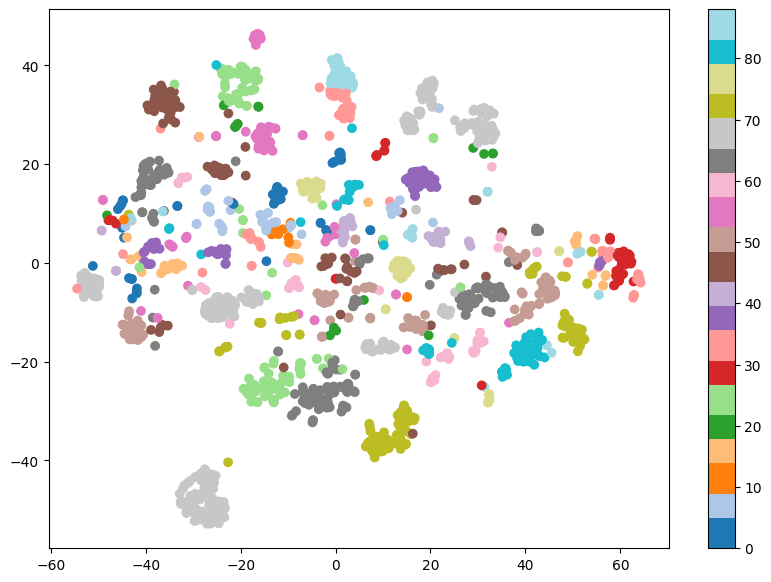

In [90]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# TODO filter db entries of individuals that are not in the dataset?

# Fit the TSNE model to the embeddings
tsne = TSNE(n_components=2)
all_embeddings = np.vstack((embeddings, embeddings_db))
embeddings_2d = tsne.fit_transform(all_embeddings)


# Split the transformed embeddings back into original and additional sets
embeddings_2d_original = embeddings_2d[:len(embeddings)]
embeddings_2d_additional = embeddings_2d[len(embeddings):]

# Get the sequence IDs and map them to individual IDs
sequence_ids = [int(imgfn_to_sequence[img_fn]) for img_fn in ids]
individual_ids = [seq_to_id[seq_id] for seq_id in sequence_ids]
print(individual_ids)

colors = plt.cm.get_cmap("tab20", len(set(sequence_ids)))
individual_ids_num_map = {ind: i for i, ind in enumerate(set(sequence_ids))}
c = [individual_ids_num_map[ind] for ind in sequence_ids]
plt.figure(figsize=(10, 7))  # Adjust the figure size if needed
plt.scatter(embeddings_2d_original[:, 0], embeddings_2d_original[:, 1], c=c, cmap=colors)
plt.colorbar()
# save the plot in high resolution
plt.savefig("/home/rohan/Documents/projects/interspecies_money/embeddings_analysis/kwitonda_portraits/embeddings/clustered_embeddings.png", dpi=300)



['KAV', 'NRJ', 'CYU', 'NTI', 'KAV', 'KHA', 'KAV', 'SUL', 'KAV', 'KAV', 'RWU', 'ICM', 'REM', 'SUL', 'RWU', 'MBI', 'SUL', 'KAV', 'KAV', 'CYU', 'INO', 'KAV', 'KAV', 'NTI', 'WIG', 'RWU', 'KAV', 'NTI', 'KAV', 'SUL', 'KAV', 'KAT', 'NRJ', 'SUL', 'RWU', 'IZO', 'KAV', 'KAV', 'KAV', 'IZO', 'KAV', 'KHA', 'RWU', 'MBI', 'MBI', 'INO', 'INO', 'KAV', 'GAH', 'KAV', 'NRJ', 'KAV', 'KAV', 'KAV', 'MBI', 'KAV', 'INO', 'SUL', 'WIG', 'RWU', 'ICM', 'NTI', 'INO', 'RWU', 'KBU', 'KAV', 'RWU', 'KAV', 'ICM', 'NTI', 'REM', 'KAV', 'ICM', 'SUL', 'GAH', 'NTI', 'NTI', 'MBI', 'GAH', 'GAH', 'NRJ', 'IZO', 'KAV', 'SUL', 'NTI', 'REM', 'KAV', 'IZO', 'NTI', 'KHA', 'KAV', 'KBU', 'MBI', 'INO', 'MBI', 'INO', 'MBI', 'MBI', 'INO', 'CYU', 'NTI', 'KAV', 'MBI', 'KHA', 'KAV', 'INO', 'ICM', 'KAV', 'NTI', 'INO', 'INO', 'KAV', 'MBI', 'WIG', 'SUL', 'KAV', 'KAV', 'KAV', 'REM', 'INO', 'SUL', 'KAV', 'KHA', 'IZO', 'CYU', 'KAV', 'MBI', 'KBU', 'REM', 'KAV', 'SUL', 'NTI', 'NTI', 'IZO', 'NRJ', 'MBI', 'MBI', 'NTI', 'KBU', 'MBI', 'KBU', 'RWU', 'WIG'

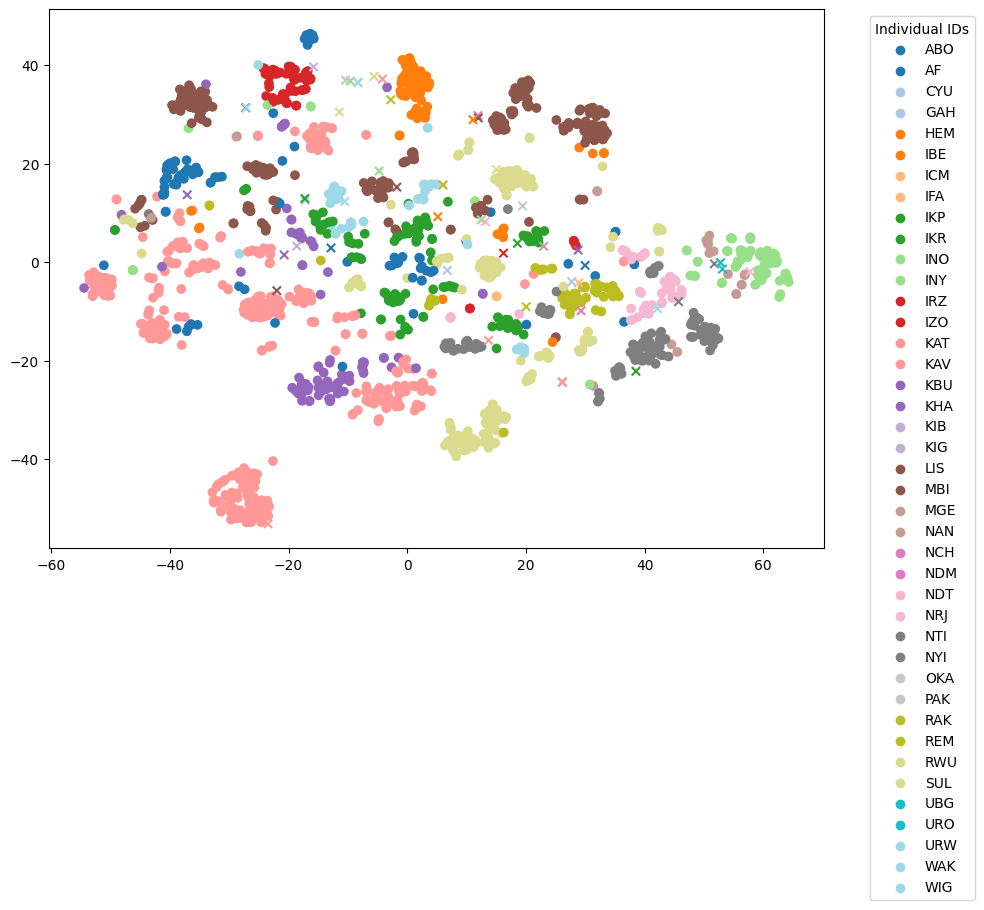

In [91]:
exclude = ["ELEPHANT", "NOT VISIBLE"]
print(individual_ids)
mask = np.array([iid not in exclude for iid in individual_ids])
embeddings_2d_original = embeddings_2d_original[mask]
individual_ids = [iid for i, iid in enumerate(individual_ids) if mask[i]]

additional_individual_ids = ids_db.tolist()

# Unique individual IDs
unique_individual_ids = sorted(set(individual_ids + additional_individual_ids))

# Color map for distinct colors
colors = plt.cm.get_cmap("tab20", len(unique_individual_ids))
individual_ids_num_map = {ind: i for i, ind in enumerate(unique_individual_ids)}
c_original = [individual_ids_num_map[ind] for ind in individual_ids]
c_additional = [individual_ids_num_map[ind] for ind in additional_individual_ids]

# Create the scatter plot
plt.figure(figsize=(10, 7))  # Adjust the figure size if needed

# Plot original embeddings
scatter_original = plt.scatter(embeddings_2d_original[:, 0], embeddings_2d_original[:, 1], 
                               c=c_original, cmap=colors, marker='o')

# Plot additional embeddings with a different marker
scatter_additional = plt.scatter(embeddings_2d_additional[:, 0], embeddings_2d_additional[:, 1], 
                                 c=c_additional, cmap=colors, marker='x')

# Create a legend with the individual IDs
legend_labels = {ind: colors(individual_ids_num_map[ind]) for ind in unique_individual_ids}
for label, color in legend_labels.items():
    plt.scatter([], [], color=color, label=label)

# Position the legend outside the plot
plt.legend(title="Individual IDs", bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the plot in high resolution
plt.savefig("/home/rohan/Documents/projects/interspecies_money/embeddings_analysis/kwitonda_portraits/embeddings/clustered_embeddings.png", dpi=300, bbox_inches='tight')


In [81]:
# Evaluate cluster quality

num_clusters_per_seq = [len(set(cluster_ids)) for cluster_ids in seq_cluster_ids.values()] 
num_clusters_per_individual = [len(set(cluster_ids)) for cluster_ids in iid_cluster_ids.values()]
print("Average number of clusters per sequence: ", np.mean(num_clusters_per_seq))
print("Average number of sequences per cluster: ", np.mean(num_sequences_per_cluster))
print("Average number of clusters per individual: ", np.mean(num_clusters_per_individual))
print("Average number of individuals per cluster: ", np.mean(num_individuals_per_cluster))

print("Number of sequences per cluster")
# for each cluster print num of sequences/total sequences in each cluster
for cluster_id, sequence_ids in sequences_per_cluster.items():
    num_imgs_in_cluster = num_imgs_per_cluster[cluster_id]
    print(f"Cluster {cluster_id}: Containes images from {len(set(sequence_ids))}/{len(sequences)} sequences. Total images in cluster: {num_imgs_in_cluster}")


print("Number of individuals per cluster")
# for each cluster print num of sindivudlas/total individuals in each cluster
for cluster_id, individual_ids in individuals_per_cluster.items():
    num_imgs_in_cluster = num_imgs_per_cluster[cluster_id]
    print(f"Cluster {cluster_id}: Containes images from {len(set(individual_ids))}/{len(set(iid_cluster_ids.keys()))} individuals. Total images in cluster: {num_imgs_in_cluster}")


Average number of clusters per sequence:  2.932584269662921
Average number of sequences per cluster:  12.428571428571429
Average number of clusters per individual:  8.1
Average number of individuals per cluster:  7.714285714285714
Number of sequences per cluster
Cluster 17: Containes images from 2/89 sequences. Total images in cluster: 65
Cluster 8: Containes images from 14/89 sequences. Total images in cluster: 90
Cluster 10: Containes images from 9/89 sequences. Total images in cluster: 90
Cluster 12: Containes images from 19/89 sequences. Total images in cluster: 105
Cluster 13: Containes images from 13/89 sequences. Total images in cluster: 107
Cluster 15: Containes images from 26/89 sequences. Total images in cluster: 147
Cluster 3: Containes images from 19/89 sequences. Total images in cluster: 80
Cluster 4: Containes images from 21/89 sequences. Total images in cluster: 43
Cluster 5: Containes images from 15/89 sequences. Total images in cluster: 86
Cluster 11: Containes images 

In [82]:
print("Number of frames per cluster for each sequence")
# for each sequence print num of frames/total frames in each cluster
for sequence_id, cluster_ids in seq_cluster_ids.items():
    cluster_counts = {cluster_id: cluster_ids.count(cluster_id) for cluster_id in set(cluster_ids)}
    # sort by count in descending order
    cluster_counts = dict(sorted(cluster_counts.items(), key=lambda item: item[1], reverse=True))
    print(f"Sequence {sequence_id}: {cluster_counts}")

Number of frames per cluster for each sequence
Sequence 69: {17: 64}
Sequence 50: {8: 20, 13: 14, 12: 7, 10: 5, 15: 4}
Sequence 63: {5: 33, 4: 2, 3: 1, 11: 1, 14: 1, 18: 1}
Sequence 72: {8: 20, 13: 16, 4: 1}
Sequence 65: {7: 63, 4: 5, 5: 3, 8: 2, 11: 2, 12: 2, 19: 2, 14: 1}
Sequence 25: {7: 8, 5: 2, 19: 2, 4: 1, 14: 1}
Sequence 57: {20: 4, 4: 2, 3: 1, 5: 1, 18: 1}
Sequence 62: {8: 6, 15: 3, 3: 2, 12: 1}
Sequence 71: {15: 20, 16: 1, 11: 1, 7: 1}
Sequence 68: {16: 85, 6: 35, 20: 2}
Sequence 58: {8: 25, 15: 11, 11: 5, 12: 3, 3: 1, 19: 1}
Sequence 87: {2: 35}
Sequence 64: {12: 38, 13: 8, 15: 6, 8: 1, 19: 1}
Sequence 39: {2: 38, 3: 1}
Sequence 73: {19: 39, 9: 21, 11: 1}
Sequence 46: {14: 46}
Sequence 75: {9: 27}
Sequence 52: {15: 5, 12: 1}
Sequence 49: {5: 32, 19: 1, 7: 1}
Sequence 66: {15: 16, 12: 7, 7: 2}
Sequence 82: {11: 8, 12: 7, 15: 2, 2: 1, 9: 1, 13: 1, 19: 1}
Sequence 24: {18: 54}
Sequence 30: {10: 35, 20: 1}
Sequence 37: {20: 10, 3: 9, 11: 3}
Sequence 38: {10: 5}
Sequence 26: {7: 3

In [83]:
print("Number of frames from sequence per cluster")
# for each cluster print num of frames/total frames from each sequence in each cluster
for cluster_id, sequence in sequences_per_cluster.items():
    sequence_counts = {sequence_id: seq_cluster_ids[sequence_id].count(cluster_id) for sequence_id in set(sequence)}
    # sort by count in descending order
    sequence_counts = dict(sorted(sequence_counts.items(), key=lambda item: item[1], reverse=True))
    print(f"Cluster {cluster_id}: {sequence_counts}") 

Number of frames from sequence per cluster
Cluster 17: {'69': 64, '60': 1}
Cluster 8: {'58': 25, '50': 20, '72': 20, '62': 6, '80': 4, '44': 4, '47': 3, '65': 2, '84': 1, '83': 1, '74': 1, '17': 1, '64': 1, '45': 1}
Cluster 10: {'30': 35, '32': 24, '17': 8, '74': 6, '50': 5, '38': 5, '84': 4, '76': 2, '86': 1}
Cluster 12: {'64': 38, '51': 15, '67': 11, '66': 7, '50': 7, '82': 7, '79': 3, '58': 3, '65': 2, '22': 2, '47': 2, '52': 1, '18': 1, '41': 1, '20': 1, '54': 1, '62': 1, '34': 1, '5': 1}
Cluster 13: {'80': 45, '72': 16, '50': 14, '42': 13, '64': 8, '78': 4, '86': 1, '85': 1, '41': 1, '47': 1, '82': 1, '17': 1, '88': 1}
Cluster 15: {'51': 21, '71': 20, '66': 16, '40': 16, '58': 11, '15': 7, '54': 6, '64': 6, '52': 5, '2': 5, '47': 5, '28': 4, '50': 4, '79': 3, '62': 3, '88': 2, '77': 2, '33': 2, '82': 2, '67': 1, '18': 1, '22': 1, '85': 1, '42': 1, '23': 1, '27': 1}
Cluster 3: {'55': 31, '47': 12, '37': 9, '79': 6, '5': 5, '41': 2, '45': 2, '62': 2, '78': 1, '63': 1, '83': 1, '42':

In [84]:
# Possible next steps: For each cluster, check which sequences represent the same individual to identify how many 
# wrongly placed individuals are in the cluster


In [85]:
# if a sequence is distributed over multiple sequences, compute the how furthest neighbour the cluster is from the other cluster of the same sequence
# fill in the code for the dsrcibed functionality now:

# get centroids of all clusters
cluster_centroids = kmeans.cluster_centers_

cluster_distances = []
for cluster_id, _ in enumerate(cluster_centroids):
    distances = []
    for other_cluster_id, _2 in enumerate(cluster_centroids):
        distance = float(np.linalg.norm(cluster_centroids[cluster_id] - cluster_centroids[other_cluster_id]))
        distances.append(distance)
    cluster_distances.append(sorted(distances))
    
# sort all distances
    
distances = []
distance_counts = []
# for each sequence, find the cluster with the most frames
for sequence_id, cluster_ids in seq_cluster_ids.items():
    cluster_counts = {cluster_id: cluster_ids.count(cluster_id) for cluster_id in set(cluster_ids)}
    max_cluster = max(cluster_counts, key=cluster_counts.get)
    max_cluster_centroid = cluster_centroids[max_cluster]
    for cluster_id in cluster_counts:
        if cluster_id != max_cluster:
            distance = float(np.linalg.norm(max_cluster_centroid - cluster_centroids[cluster_id]))
            k = cluster_distances[max_cluster].index(distance)
            distances.append(k)
            distance_counts.extend([k]*cluster_counts[cluster_id])
            
# print count number smaller 5
print("Number of clusters that are the closest to the cluster of the same sequence: ", len([d for d in distances if d <= 4]))
print("Number of clusters that are not close to the cluster of the same sequence: ", len([d for d in distances if d > 4]))

print(np.mean([d for d in distances if d >5]))
print("Average distance between clusters of the same sequence: ", np.mean(distances))

print("Average distance between clusters of the same sequence (image count): ", np.mean(distance_counts))

Number of clusters that are the closest to the cluster of the same sequence:  76
Number of clusters that are not close to the cluster of the same sequence:  96
11.240963855421686
Average distance between clusters of the same sequence:  6.877906976744186
Average distance between clusters of the same sequence (image count):  6.006302521008403


In [86]:
# if a individual is distributed over multiple clusters, compute the how furthest neighbour the cluster is from the other cluster of the same individual
# fill in the code for the dsrcibed functionality now:

# get centroids of all clusters
cluster_centroids = kmeans.cluster_centers_

cluster_distances = []
for cluster_id, _ in enumerate(cluster_centroids):
    distances = []
    for other_cluster_id, _2 in enumerate(cluster_centroids):
        distance = float(np.linalg.norm(cluster_centroids[cluster_id] - cluster_centroids[other_cluster_id]))
        distances.append(distance)
    cluster_distances.append(sorted(distances))
    
# sort all distances

distances = []
distance_counts = []
# for each individual, find the cluster with the most frames
for iid, cluster_ids in iid_cluster_ids.items():
    cluster_counts = {cluster_id: cluster_ids.count(cluster_id) for cluster_id in set(cluster_ids)}
    max_cluster = max(cluster_counts, key=cluster_counts.get)
    max_cluster_centroid = cluster_centroids[max_cluster]
    for cluster_id in cluster_counts:
        if cluster_id != max_cluster:
            distance = float(np.linalg.norm(max_cluster_centroid - cluster_centroids[cluster_id]))
            k = cluster_distances[max_cluster].index(distance)
            distances.append(k)
            distance_counts.extend([k]*cluster_counts[cluster_id])
            
# print count number smaller 5
print("Number of clusters that are the closest to the cluster of the same individual: ", len([d for d in distances if d <= 4]))
print("Number of clusters that are not close to the cluster of the same individual: ", len([d for d in distances if d > 4]))

print(np.mean([d for d in distances if d >5]))
print("Average distance between clusters of the same individual: ", np.mean(distances))

print("Average distance between clusters of the same individual (image count): ", np.mean(distance_counts))


Number of clusters that are the closest to the cluster of the same individual:  48
Number of clusters that are not close to the cluster of the same individual:  94
12.047058823529412
Average distance between clusters of the same individual:  8.330985915492958
Average distance between clusters of the same individual (image count):  6.6984615384615385
